In [1]:
import numpy as np
from scipy.linalg import expm
import pandas as pd
from scipy.sparse import diags

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator

# Set the font to Times New Roman for the whole plot
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'

## Functions

In [2]:
# Optimal controls verification
def optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y,
                     S,z_2,delta_a_2,delta_b_2):
    
    K=k_matrix(N_1, lambda_a, lambda_b, phi1, kappa1, Y_1, hat_y1, S, z_2, delta_a_2, delta_b_2)
    w=W_t_function(alpha1, kappa1, zeta, Y_1, hat_y1, K, t, T)
    
    
    h1_1st=h1_function(zeta,kappa1,w,y,Y_1);
    h1_2nd=h1_function(zeta,kappa1,w,y+zeta,Y_1);
    h1_3rd=h1_function(zeta,kappa1,w,y-zeta,Y_1);
    z= m2_1/(y**2);
    delta_b_star = (1 / (2 * kappa1)) + (h1_1st - h1_2nd) / zeta + (z - S)
    delta_a_star = (1 / (2 * kappa1)) + (h1_1st - h1_3rd) / zeta + (S - z)
    return delta_b_star, delta_a_star

In [3]:
#level functions and derivative
def lvlfct(m_2, y):
    return m_2/y;

def lvlfct_deriv(m_2,y):
    return -m_2/y**2

In [4]:
# h1 and H1
def h1_function(zeta, kappa, w, y, Y_1):
    # Find entries in w where Y_1 matches y
    w=np.sqrt(w)
    matched_w = w[Y_1 == y]
    # Check if the matched_w array is empty
    if matched_w.size == 0:
        return np.nan  # Return np.nan if y is not found in Y_1
    else:
        # Calculate h1 if there is at least one match
        h1 = (zeta / kappa) * np.log(matched_w.item())  # Assuming only one match; use matched_w[0] if multiple matches are handled differently
        return h1
    
def H1_function(x,y,S,h1):
    H1=x+y*S+h1
    return H1

In [5]:
#W_t
def W_t_function(alpha1, kappa1, zeta, Y_1, hat_y1, K, t, T):
    exponent_values = -alpha1 * kappa1 / zeta * (Y_1 - hat_y1)**2
    W0 = (np.exp(exponent_values)) **2
    W_t = expm(K * (T-t)).dot(W0)
    return W_t

In [6]:
def k_matrix(N_1, lambda_a, lambda_b, phi1, kappa1, Y_1, hat_y1, S, z_2, delta_a_2, delta_b_2):
    # The main diagonal values
    main_diag = -2 * kappa1 * phi1 * (Y_1 - hat_y1)**2 / zeta

    # Subdiagonal and superdiagonal values
    sub_diag = lambda_a * np.exp(-kappa1 * S + kappa1 * z_2 + kappa1 * delta_a_2 - 1) * np.ones(N_1)  
    super_diag = lambda_b * np.exp(kappa1 * S - kappa1 * z_2 + kappa1 * delta_b_2 - 1) * np.ones(N_1)

    # Create the tridiagonal sparse matrix
    diagonals = [sub_diag, main_diag, super_diag]
    K = diags(diagonals, offsets=[-1, 0, 1], shape=(N_1+1, N_1+1), format='csr')
    
    return K.todense()

## Parameters and initial assumptions

In [7]:
# AMM settings and Perfparameters
zeta = 1
T = 30 #seconds
lambda_a = 1
lambda_b = 1

In [8]:
# LP1 reserves and settings
x0_1=1; #60kUSDC
y0_1=1; #20ETH
z0_1=x0_1/y0_1; #initial marginal rate
m2_1=x0_1*y0_1;

y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)
Z_1 = m2_1 / (Y_1 ** 2 + 1e-10)  # Adding a small constant to avoid division by zero

phi1 = 10**(-5) # No inventory penalty
alpha1 = 0.001 # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y

In [9]:
# LP2 reserves and settings
z_2=z0_1;
delta_a_2=0.1;
delta_b_2=0.1;

In [10]:
#LOB setting
S=x0_1/y0_1; # assumed equal to initial marginal rate at time 0
sigma=0.01;

## Proposition 1

### Testing

In [11]:
t=29
delta_b_star, delta_a_star = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y0_1,
                     S,z_2,delta_a_2,delta_b_2)
print(f"Optimal delta_b_star: {delta_b_star}")
print(f"Optimal delta_a_star: {delta_a_star}")

Optimal delta_b_star: 0.058239195676191804
Optimal delta_a_star: 0.04797321604912187


In [12]:
K=k_matrix(N_1, lambda_a, lambda_b, phi1, kappa1, Y_1, hat_y1, S, z_2, delta_a_2, delta_b_2)

In [13]:
w=W_t_function(alpha1, kappa1, zeta, Y_1, hat_y1, K, t, T);
w

array([3.48284899, 5.70409518, 6.72591707, 7.00415793, 6.72591707,
       5.70409518, 3.48284899])

In [14]:
z= m2_1/(y0_1**2);
z

1.0

In [15]:
S

1.0

In [16]:
h1_1st=h1_function(zeta,kappa1,w,y0_1,Y_1);
print(h1_1st)

0.09529841416063581


In [17]:
h1_2nd=h1_function(zeta,kappa1,w,y0_1+zeta,Y_1);
print(h1_2nd)

0.087059218484444


In [18]:
h1_3rd=h1_function(zeta,kappa1,w,y0_1-zeta,Y_1);
print(h1_3rd)

0.09732519811151394


In [19]:
delta_b_star = (1 / (2 * kappa1)) + (h1_1st - h1_2nd) / zeta + (z - S)
delta_b_star

0.058239195676191804

In [20]:
delta_a_star = (1 / (2 * kappa1)) + (h1_1st - h1_3rd) / zeta + (S - z)
delta_a_star

0.04797321604912187

### Simulations

### Simulating for non-competitive LP2: S=Z, different y values with Z constant, y_hat=0
We will compare how the depth of an LP would vary as he is far away from his objective

In [21]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-5) # No inventory penalty
alpha1 = 0.001 # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y

delta_a_2=0.5;
delta_b_2=0.5;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_1 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_1 = np.zeros((len(y_test_range),len(t_grid)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_1[i,j], delta_a_star_1[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2,delta_a_2,delta_b_2)

/Users/alexisaber/anaconda3/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_33769/3635420665.py:16: RuntimeWarning: invalid value encountered in scalar subtract
  delta_b_star = (1 / (2 * kappa1)) + (h1_1st - h1_2nd) / zeta + (z - S)
/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_33769/3635420665.py:17: RuntimeWarning: invalid value encountered in scalar subtract
  delta_a_star = (1 / (2 * kappa1)) + (h1_1st - h1_3rd) / zeta + (S - z)


In [22]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi11 = np.linspace(10**(-1),10**(-5)) # No inventory penalty
alpha1 = 0.001 # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y

delta_a_2=0.5;
delta_b_2=0.5;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[76]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_2 = np.zeros((len(y_test_range),len(phi11)))
delta_a_star_2 = np.zeros((len(y_test_range),len(phi11)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, phi in enumerate(phi11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_2[i,j], delta_a_star_2[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2,delta_a_2,delta_b_2)

In [23]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-5) # No inventory penalty
alpha11 = np.linspace(10**(-1),10**(-3)) # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y

delta_a_2=0.5;
delta_b_2=0.5;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[-1]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_3 = np.zeros((len(y_test_range),len(alpha11)))
delta_a_star_3 = np.zeros((len(y_test_range),len(alpha11)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, alpha in enumerate(alpha11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_3[i,j], delta_a_star_3[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2,delta_a_2,delta_b_2)

In [24]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-5) # No inventory penalty
alpha1 = 10**(-3) # No terminal penalty
kappa11= np.linspace(1,30)
hat_y1 = 0 #objective y

delta_a_2=0.5;
delta_b_2=0.5;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[5]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_4 = np.zeros((len(y_test_range),len(kappa11)))
delta_a_star_4 = np.zeros((len(y_test_range),len(kappa11)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, kappa in enumerate(kappa11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_4[i,j], delta_a_star_4[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2,delta_a_2,delta_b_2)

/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_33769/3635420665.py:16: RuntimeWarning: invalid value encountered in scalar subtract
  delta_b_star = (1 / (2 * kappa1)) + (h1_1st - h1_2nd) / zeta + (z - S)
/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_33769/3635420665.py:17: RuntimeWarning: invalid value encountered in scalar subtract
  delta_a_star = (1 / (2 * kappa1)) + (h1_1st - h1_3rd) / zeta + (S - z)


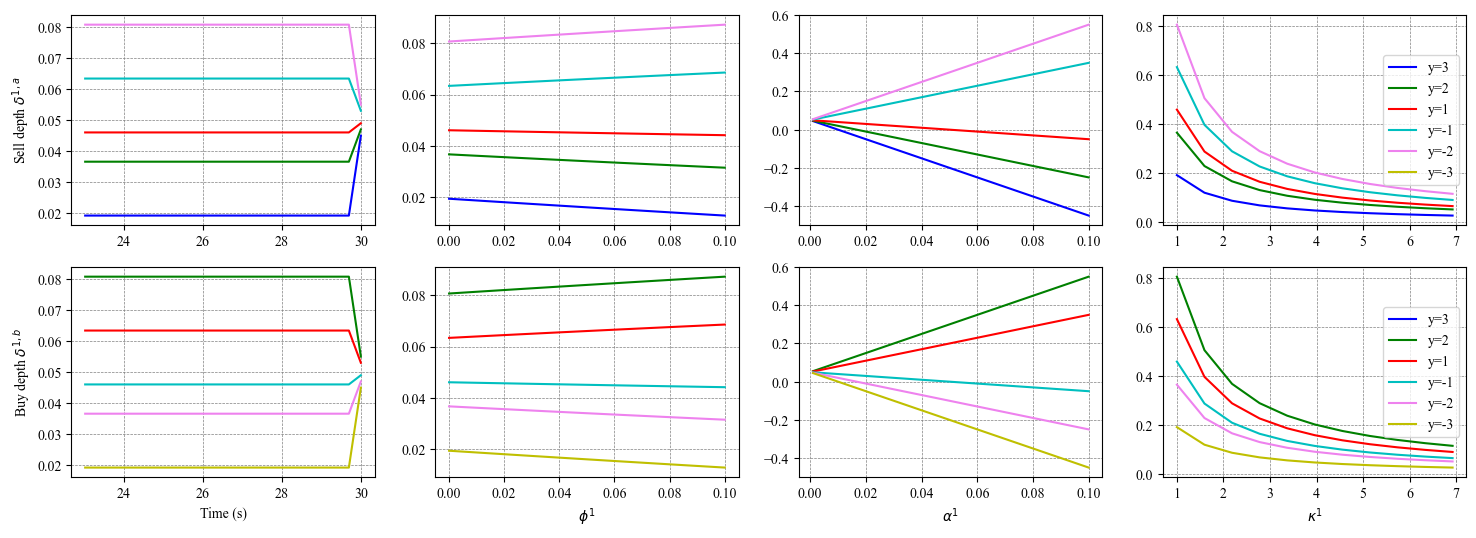

In [25]:
plt.figure(figsize=(18,6))


plt.subplot(2,4,1)
plt.plot(t_grid,delta_a_star_1[5,:],'b',label='$y=3$')
plt.plot(t_grid,delta_a_star_1[4,:],'g',label='$y=2$')
plt.plot(t_grid,delta_a_star_1[3,:],'r',label='$y=1$')
plt.plot(t_grid,delta_a_star_1[2,:],'c',label='$y=-1$')
plt.plot(t_grid,delta_a_star_1[1,:],'violet',label='$y=-2$')
plt.plot(t_grid,delta_a_star_1[0,:],'y',label='$y=-3$')
plt.ylabel(r'Sell depth $\delta^{1,a}$')  # Using raw string for LaTeX compatibility
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,5)
plt.plot(t_grid,delta_b_star_1[5,:],'b',label='y=3')
plt.plot(t_grid,delta_b_star_1[4,:],'g',label='y=2')
plt.plot(t_grid,delta_b_star_1[3,:],'r',label='y=1')
plt.plot(t_grid,delta_b_star_1[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_b_star_1[1,:],'violet',label='y-2')
plt.plot(t_grid,delta_b_star_1[0,:],'y',label='y=-3')
plt.xlabel('Time (s)')
plt.ylabel(r'Buy depth $\delta^{1,b}$')  # Using raw string for LaTeX compatibility
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.subplot(2,4,2)
plt.plot(phi11,delta_a_star_2[5,:],'b',label='y=3')
plt.plot(phi11,delta_a_star_2[4,:],'g',label='y=2')
plt.plot(phi11,delta_a_star_2[3,:],'r',label='y=1')
plt.plot(phi11,delta_a_star_2[2,:],'c',label='y=-1')
plt.plot(phi11,delta_a_star_2[1,:],'violet',label='y=-2')
plt.plot(phi11,delta_a_star_2[0,:],'y',label='y=-3')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,6)
plt.plot(phi11,delta_b_star_2[5,:],'b',label='y=3')
plt.plot(phi11,delta_b_star_2[4,:],'g',label='y=2')
plt.plot(phi11,delta_b_star_2[3,:],'r',label='y=1')
plt.plot(phi11,delta_b_star_2[2,:],'c',label='y=-1')
plt.plot(phi11,delta_b_star_2[1,:],'violet',label='y-2')
plt.plot(phi11,delta_b_star_2[0,:],'y',label='y=-3')
plt.xlabel('$\\phi^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.subplot(2,4,3)
plt.plot(alpha11,delta_a_star_3[5,:],'b',label='y=3')
plt.plot(alpha11,delta_a_star_3[4,:],'g',label='y=2')
plt.plot(alpha11,delta_a_star_3[3,:],'r',label='y=1')
plt.plot(alpha11,delta_a_star_3[2,:],'c',label='y=-1')
plt.plot(alpha11,delta_a_star_3[1,:],'violet',label='y=-2')
plt.plot(alpha11,delta_a_star_3[0,:],'y',label='y=-3')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,7)
plt.plot(alpha11,delta_b_star_3[5,:],'b',label='y=3')
plt.plot(alpha11,delta_b_star_3[4,:],'g',label='y=2')
plt.plot(alpha11,delta_b_star_3[3,:],'r',label='y=1')
plt.plot(alpha11,delta_b_star_3[2,:],'c',label='y=-1')
plt.plot(alpha11,delta_b_star_3[1,:],'violet',label='y-2')
plt.plot(alpha11,delta_b_star_3[0,:],'y',label='y=-3')
plt.xlabel('$\\alpha^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.subplot(2,4,4)
plt.plot(kappa11,delta_a_star_4[5,:],'b',label='y=3')
plt.plot(kappa11,delta_a_star_4[4,:],'g',label='y=2')
plt.plot(kappa11,delta_a_star_4[3,:],'r',label='y=1')
plt.plot(kappa11,delta_a_star_4[2,:],'c',label='y=-1')
plt.plot(kappa11,delta_a_star_4[1,:],'violet',label='y=-2')
plt.plot(kappa11,delta_a_star_4[0,:],'y',label='y=-3')
plt.legend(loc='center right')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,8)
plt.plot(kappa11,delta_b_star_4[5,:],'b',label='y=3')
plt.plot(kappa11,delta_b_star_4[4,:],'g',label='y=2')
plt.plot(kappa11,delta_b_star_4[3,:],'r',label='y=1')
plt.plot(kappa11,delta_b_star_4[2,:],'c',label='y=-1')
plt.plot(kappa11,delta_b_star_4[1,:],'violet',label='y=-2')
plt.plot(kappa11,delta_b_star_4[0,:],'y',label='y=-3')
plt.legend(loc='center right')
plt.xlabel('$\\kappa^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks




# If you need to set ticks in Times New Roman, ensure this by setting tick labels explicitly if needed
# Example to set x-ticks (similarly for y-ticks):
plt.xticks(fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')
plt.savefig('General analysis Model 1.a.png', format='png', dpi=300, bbox_inches='tight')

We can see that as y_hat is the objective against which there is a terminal and inventory penalty, the MM wants to reach 0. The figure shows the behaviour of the optimal depths as a function of time for different inventory levels. In the examples, the arrival rate of MOs is lambda a=lambda b=1 (i.e., there are on average 1 buy and 1 sell MO per second), max y=-min y =3, and phi=10^-5. On the left, we show the optimal sell postings delta^a, i.e., upon the arrival of a market buy order the MM is willing to sell one unit of the asset at the price S_t +delta^a, and in the right, we show the optimal buy postings delta^a. For example, when the strategy is away from expiry (T=30 seconds) and inventories are closed to allowed minimum (e.g., y=-2), the optimal sell postings is further away from the midprice (delta^a=0.081) bcs only at a very high price is the LP willing to decrease the inventory further, and at the same time the optimal buy is close to the midprice (delta^b=0.037) bcs the LP would like to complete round-trip trades (i.e., a buy followed by a sell or a sell followed by a buy) and push inventories to zeros. TRY CHANGING y_hat

We also observe that as the strategy approaches T and y<0 (e.g.,y=-2), the optimal sell decreases (delta^a: from 0.081 to 0.055) and the optimal buy increases (delta^b: from 0.037 to 0.046). To understand this, not that if the terminal inventory y<0 is liquidated, then when the terminal penalty alpha is very small as well as being fractions of seconds away of T, it is optimal to post nearer the midprice to increase the chances of being filled (i.e., selling one more unit of the asset) because the price is not expected to move too much before expiry and the entire position will be unwound at the midprice - making a profit on the last asset that was sold.

In [26]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-5) # No inventory penalty
alpha1 = 0.001 # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y

delta_a_2=0.5;
delta_b_2=0.5;
S_change=np.linspace(0.8,1.2)

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[80]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star = np.zeros((len(y_test_range),len(S_change)))
delta_a_star = np.zeros((len(y_test_range),len(S_change)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, S_delta in enumerate(S_change):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test*S_delta
        
        delta_b_star[i,j], delta_a_star[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2_test,delta_a_2,delta_b_2)

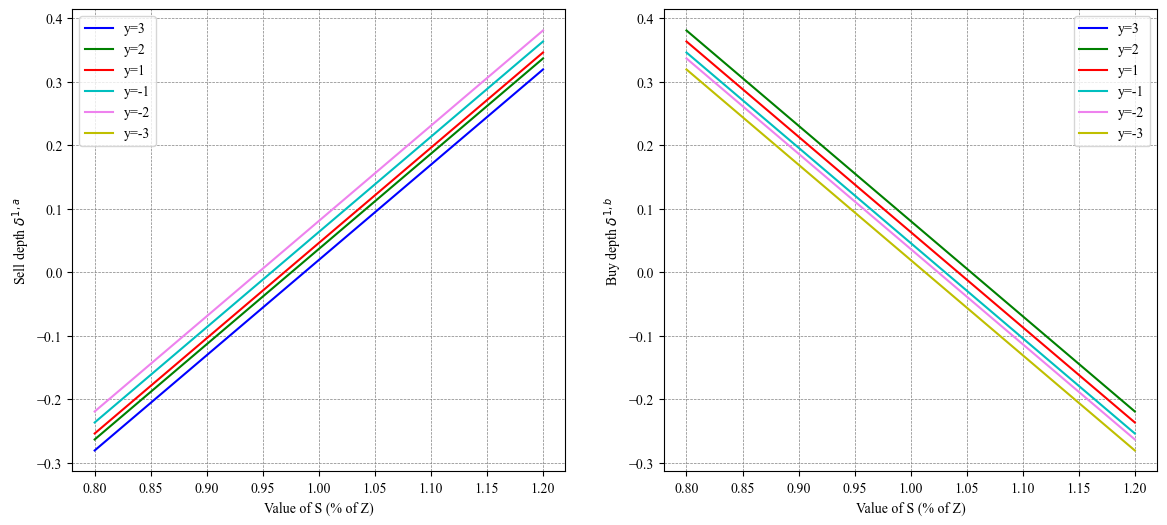

In [27]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(S_change,delta_a_star[5,:],'b',label='y=3')
plt.plot(S_change,delta_a_star[4,:],'g',label='y=2')
plt.plot(S_change,delta_a_star[3,:],'r',label='y=1')
plt.plot(S_change,delta_a_star[2,:],'c',label='y=-1')
plt.plot(S_change,delta_a_star[1,:],'violet',label='y=-2')
plt.plot(S_change,delta_a_star[0,:],'y',label='y=-3')
plt.legend()
plt.xlabel('Value of S (% of Z)')
plt.ylabel('Sell depth $\delta^{1,a}$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(1,2,2)
plt.plot(S_change,delta_b_star[5,:],'b',label='y=3')
plt.plot(S_change,delta_b_star[4,:],'g',label='y=2')
plt.plot(S_change,delta_b_star[3,:],'r',label='y=1')
plt.plot(S_change,delta_b_star[2,:],'c',label='y=-1')
plt.plot(S_change,delta_b_star[1,:],'violet',label='y=-2')
plt.plot(S_change,delta_b_star[0,:],'y',label='y=-3')
plt.legend()
plt.xlabel('Value of S (% of Z)')
plt.ylabel('Buy depth $\delta^{1,b}$');
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.savefig('Varying value of S Model 1.a.png', format='png', dpi=300, bbox_inches='tight')

In [79]:
lambda_a= 1
lambda_b= 1

y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-5) # No inventory penalty
alpha1 = 0.001 # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y

delta_a_2=0.5;
delta_b_2=0.5;
Z_change=np.linspace(0.8,1.2)

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[80]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star = np.zeros((len(y_test_range),len(Z_change)))
delta_a_star = np.zeros((len(y_test_range),len(Z_change)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, Z_delta in enumerate(Z_change):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_22_test=z_test * Z_delta
        Snew=z_test
        
        delta_b_star[i,j], delta_a_star[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     Snew,z_22_test,delta_a_2,delta_b_2)

In [80]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-5) # No inventory penalty
alpha1 = 0.001 # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y

delta_a_2=0.01;
delta_b_2=0.01;
Z_change=np.linspace(0.8,1.2)

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[80]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_Z = np.zeros((len(y_test_range),len(Z_change)))
delta_a_star_Z = np.zeros((len(y_test_range),len(Z_change)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, Z_delta in enumerate(Z_change):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_22_test=z_test * Z_delta
        Snew=z_test
        
        delta_b_star_Z[i,j], delta_a_star_Z[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     Snew,z_22_test,delta_a_2,delta_b_2)

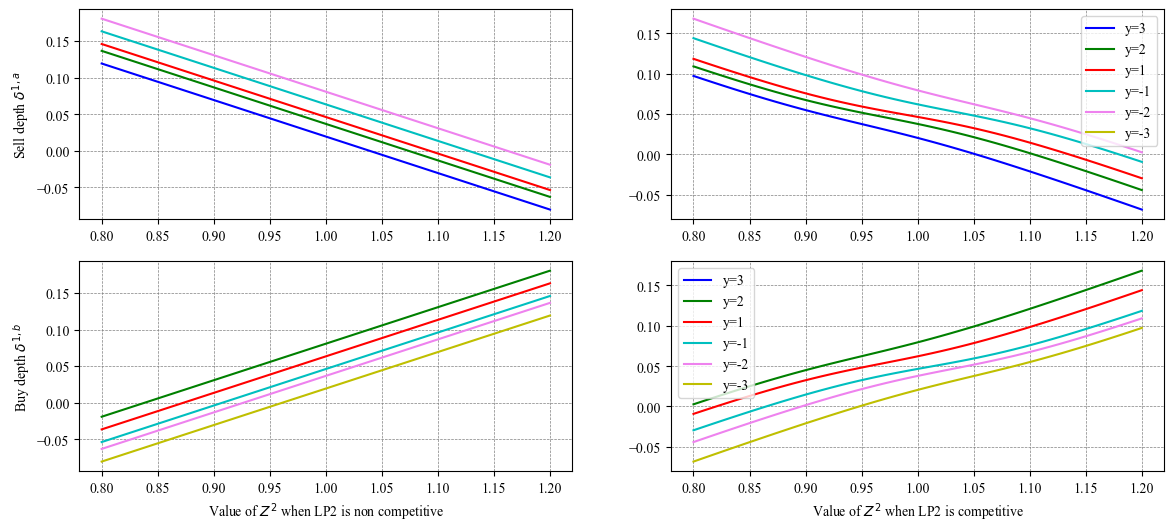

In [81]:
plt.figure(figsize=(14,6))
plt.subplot(2,2,1)
plt.plot(Z_change,delta_a_star[5,:],'b',label='y=3')
plt.plot(Z_change,delta_a_star[4,:],'g',label='y=2')
plt.plot(Z_change,delta_a_star[3,:],'r',label='y=1')
plt.plot(Z_change,delta_a_star[2,:],'c',label='y=-1')
plt.plot(Z_change,delta_a_star[1,:],'violet',label='y=-2')
plt.plot(Z_change,delta_a_star[0,:],'y',label='y=-3')
plt.ylabel('Sell depth $\delta^{1,a}$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks

plt.subplot(2,2,2)
plt.plot(Z_change,delta_a_star_Z[5,:],'b',label='y=3')
plt.plot(Z_change,delta_a_star_Z[4,:],'g',label='y=2')
plt.plot(Z_change,delta_a_star_Z[3,:],'r',label='y=1')
plt.plot(Z_change,delta_a_star_Z[2,:],'c',label='y=-1')
plt.plot(Z_change,delta_a_star_Z[1,:],'violet',label='y=-2')
plt.plot(Z_change,delta_a_star_Z[0,:],'y',label='y=-3')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.legend()
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,2,3)
plt.plot(Z_change,delta_b_star[5,:],'b',label='y=3')
plt.plot(Z_change,delta_b_star[4,:],'g',label='y=2')
plt.plot(Z_change,delta_b_star[3,:],'r',label='y=1')
plt.plot(Z_change,delta_b_star[2,:],'c',label='y=-1')
plt.plot(Z_change,delta_b_star[1,:],'violet',label='y=-2')
plt.plot(Z_change,delta_b_star[0,:],'y',label='y=-3')
plt.xlabel('Value of $Z^2$ when LP2 is non competitive')
plt.ylabel('Buy depth $\delta^{1,b}$');
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)


plt.subplot(2,2,4)
plt.plot(Z_change,delta_b_star_Z[5,:],'b',label='y=3')
plt.plot(Z_change,delta_b_star_Z[4,:],'g',label='y=2')
plt.plot(Z_change,delta_b_star_Z[3,:],'r',label='y=1')
plt.plot(Z_change,delta_b_star_Z[2,:],'c',label='y=-1')
plt.plot(Z_change,delta_b_star_Z[1,:],'violet',label='y=-2')
plt.plot(Z_change,delta_b_star_Z[0,:],'y',label='y=-3')
plt.legend()
plt.xlabel('Value of $Z^2$ when LP2 is competitive');
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

plt.savefig('Varying competing Z Model 1.a.png', format='png', dpi=300, bbox_inches='tight')

In [31]:
lambda_a=1;
lambda_b=1;
zeta=1;
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-5) # No inventory penalty
alpha1 = 0.001 # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y
T=30;

delta_a_2=np.linspace(0,0.2,100);
delta_b_2=np.linspace(0,0.2,100);

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[10]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star = np.zeros((len(y_test_range),len(delta_a_2),len(delta_b_2)))
delta_a_star = np.zeros((len(y_test_range),len(delta_a_2),len(delta_b_2)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j in range(len(delta_a_2)):
        for k in range(len(delta_b_2)):
            x_test=y_test
            z_test=x_test/y_test
            m2_1=x_test*y_test;
            z_2_test=z_test
            S_new=z_test

            delta_b_star[i,j,k], delta_a_star[i,j,k] = optimal_controls(t,T,
                         N_1,zeta,
                         lambda_a,lambda_b,alpha1,phi1,kappa1,
                         Y_1,hat_y1,m2_1,y_test,
                         S_new,z_2_test,delta_a_2[j],delta_b_2[k])

In [32]:
corr_delta_a_2_delta_a_star = np.corrcoef(delta_a_2, delta_a_star[1,:,:])[0, 1]
corr_delta_b_2_delta_a_star = np.corrcoef(delta_b_2, delta_a_star[1,:,:])[0, 1]

print('Correlation between X and Z:', corr_delta_a_2_delta_a_star)
print('Correlation between Y and Z:', corr_delta_b_2_delta_a_star)

Correlation between X and Z: 0.9999997920847467
Correlation between Y and Z: 0.9999997920847467


In [33]:
X_delta_a_2, Y_delta_b_2 = np.meshgrid(delta_a_2, delta_b_2)

# Check shapes
print("Shapes - X:", X_delta_a_2.shape, "Y:", Y_delta_b_2.shape, "Z:", delta_a_star[5,:,:].shape)

Shapes - X: (100, 100) Y: (100, 100) Z: (100, 100)


In [34]:
df=pd.DataFrame(delta_b_star[3,:,:])
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.063452,0.062953,0.062454,0.061955,0.061455,0.060954,0.060453,0.059951,0.059449,0.058947,...,0.017949,0.017444,0.016938,0.016433,0.015928,0.015422,0.014917,0.014411,0.013906,0.013400
1,0.063948,0.063450,0.062951,0.062452,0.061952,0.061451,0.060950,0.060448,0.059946,0.059444,...,0.018454,0.017949,0.017443,0.016938,0.016432,0.015927,0.015421,0.014916,0.014411,0.013905
2,0.064446,0.063947,0.063448,0.062949,0.062449,0.061948,0.061447,0.060946,0.060444,0.059941,...,0.018959,0.018453,0.017948,0.017442,0.016937,0.016431,0.015926,0.015421,0.014915,0.014410
3,0.064943,0.064445,0.063946,0.063447,0.062947,0.062446,0.061945,0.061444,0.060942,0.060440,...,0.019463,0.018958,0.018452,0.017947,0.017442,0.016936,0.016431,0.015925,0.015420,0.014915
4,0.065442,0.064944,0.064445,0.063945,0.063445,0.062945,0.062444,0.061942,0.061441,0.060938,...,0.019968,0.019463,0.018957,0.018452,0.017946,0.017441,0.016935,0.016430,0.015925,0.015419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.111381,0.110875,0.110370,0.109865,0.109359,0.108854,0.108349,0.107843,0.107338,0.106833,...,0.065908,0.065403,0.064898,0.064392,0.063887,0.063382,0.062877,0.062372,0.061867,0.061361
96,0.111885,0.111380,0.110875,0.110369,0.109864,0.109359,0.108854,0.108348,0.107843,0.107338,...,0.066413,0.065908,0.065402,0.064897,0.064392,0.063887,0.063382,0.062877,0.062371,0.061866
97,0.112390,0.111885,0.111380,0.110874,0.110369,0.109864,0.109358,0.108853,0.108348,0.107842,...,0.066918,0.066413,0.065907,0.065402,0.064897,0.064392,0.063887,0.063382,0.062876,0.062371
98,0.112895,0.112390,0.111884,0.111379,0.110874,0.110368,0.109863,0.109358,0.108852,0.108347,...,0.067423,0.066917,0.066412,0.065907,0.065402,0.064897,0.064392,0.063886,0.063381,0.062876


In [35]:
max_value = df.values.max()
max_pos = np.unravel_index(df.values.argmax(), df.shape)

# Finding the minimum value and its position
min_value = df.values.min()
min_pos = np.unravel_index(df.values.argmin(), df.shape)


x_max, y_max = delta_a_2[max_pos[1]], delta_b_2[max_pos[0]]
x_min, y_min = delta_a_2[min_pos[1]], delta_b_2[min_pos[0]]

print("Maximum value:", max_value)
print("Obtained at x =", x_max, "and y =", y_max)
print("Minimum value:", min_value)
print("Obtained at x =", x_min, "and y =", y_min)

Maximum value: 0.1133997839271494
Obtained at x = 0.0 and y = 0.2
Minimum value: 0.013400496928266128
Obtained at x = 0.2 and y = 0.0


In [36]:
dff=pd.DataFrame(delta_a_star[3,:,:])
dff

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.046011,0.046507,0.047004,0.047502,0.048001,0.048500,0.049000,0.049500,0.050001,0.050503,...,0.091482,0.091988,0.092493,0.092998,0.093503,0.094009,0.094514,0.095019,0.095524,0.096030
1,0.045515,0.046011,0.046509,0.047006,0.047505,0.048004,0.048504,0.049004,0.049505,0.050007,...,0.090978,0.091483,0.091988,0.092493,0.092999,0.093504,0.094009,0.094514,0.095020,0.095525
2,0.045018,0.045515,0.046012,0.046510,0.047008,0.047507,0.048007,0.048508,0.049008,0.049510,...,0.090473,0.090978,0.091483,0.091989,0.092494,0.092999,0.093504,0.094009,0.094515,0.095020
3,0.044521,0.045018,0.045515,0.046013,0.046511,0.047010,0.047510,0.048010,0.048511,0.049012,...,0.089968,0.090473,0.090978,0.091484,0.091989,0.092494,0.092999,0.093505,0.094010,0.094515
4,0.044023,0.044520,0.045017,0.045515,0.046013,0.046512,0.047012,0.047512,0.048013,0.048514,...,0.089463,0.089968,0.090474,0.090979,0.091484,0.091989,0.092494,0.093000,0.093505,0.094010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.001950,-0.001444,-0.000939,-0.000434,0.000071,0.000576,0.001081,0.001586,0.002091,0.002596,...,0.043511,0.044016,0.044522,0.045027,0.045532,0.046037,0.046542,0.047047,0.047552,0.048057
96,-0.002455,-0.001949,-0.001444,-0.000939,-0.000434,0.000071,0.000576,0.001081,0.001586,0.002091,...,0.043006,0.043511,0.044017,0.044522,0.045027,0.045532,0.046037,0.046542,0.047047,0.047552
97,-0.002960,-0.002454,-0.001949,-0.001444,-0.000939,-0.000434,0.000071,0.000576,0.001081,0.001587,...,0.042501,0.043006,0.043512,0.044017,0.044522,0.045027,0.045532,0.046037,0.046542,0.047047
98,-0.003465,-0.002959,-0.002454,-0.001949,-0.001444,-0.000939,-0.000434,0.000071,0.000576,0.001082,...,0.041996,0.042501,0.043007,0.043512,0.044017,0.044522,0.045027,0.045532,0.046037,0.046542


In [37]:
max_value = dff.values.max()
max_pos = np.unravel_index(dff.values.argmax(), dff.shape)

# Finding the minimum value and its position
min_value = dff.values.min()
min_pos = np.unravel_index(dff.values.argmin(), dff.shape)


x_max, y_max = delta_a_2[max_pos[1]], delta_b_2[max_pos[0]]
x_min, y_min = delta_a_2[min_pos[1]], delta_b_2[min_pos[0]]

print("Maximum value:", max_value)
print("Obtained at x =", x_max, "and y =", y_max)
print("Minimum value:", min_value)
print("Obtained at x =", x_min, "and y =", y_min)

Maximum value: 0.09602961641068593
Obtained at x = 0.2 and y = 0.0
Minimum value: -0.003969542744865426
Obtained at x = 0.0 and y = 0.2


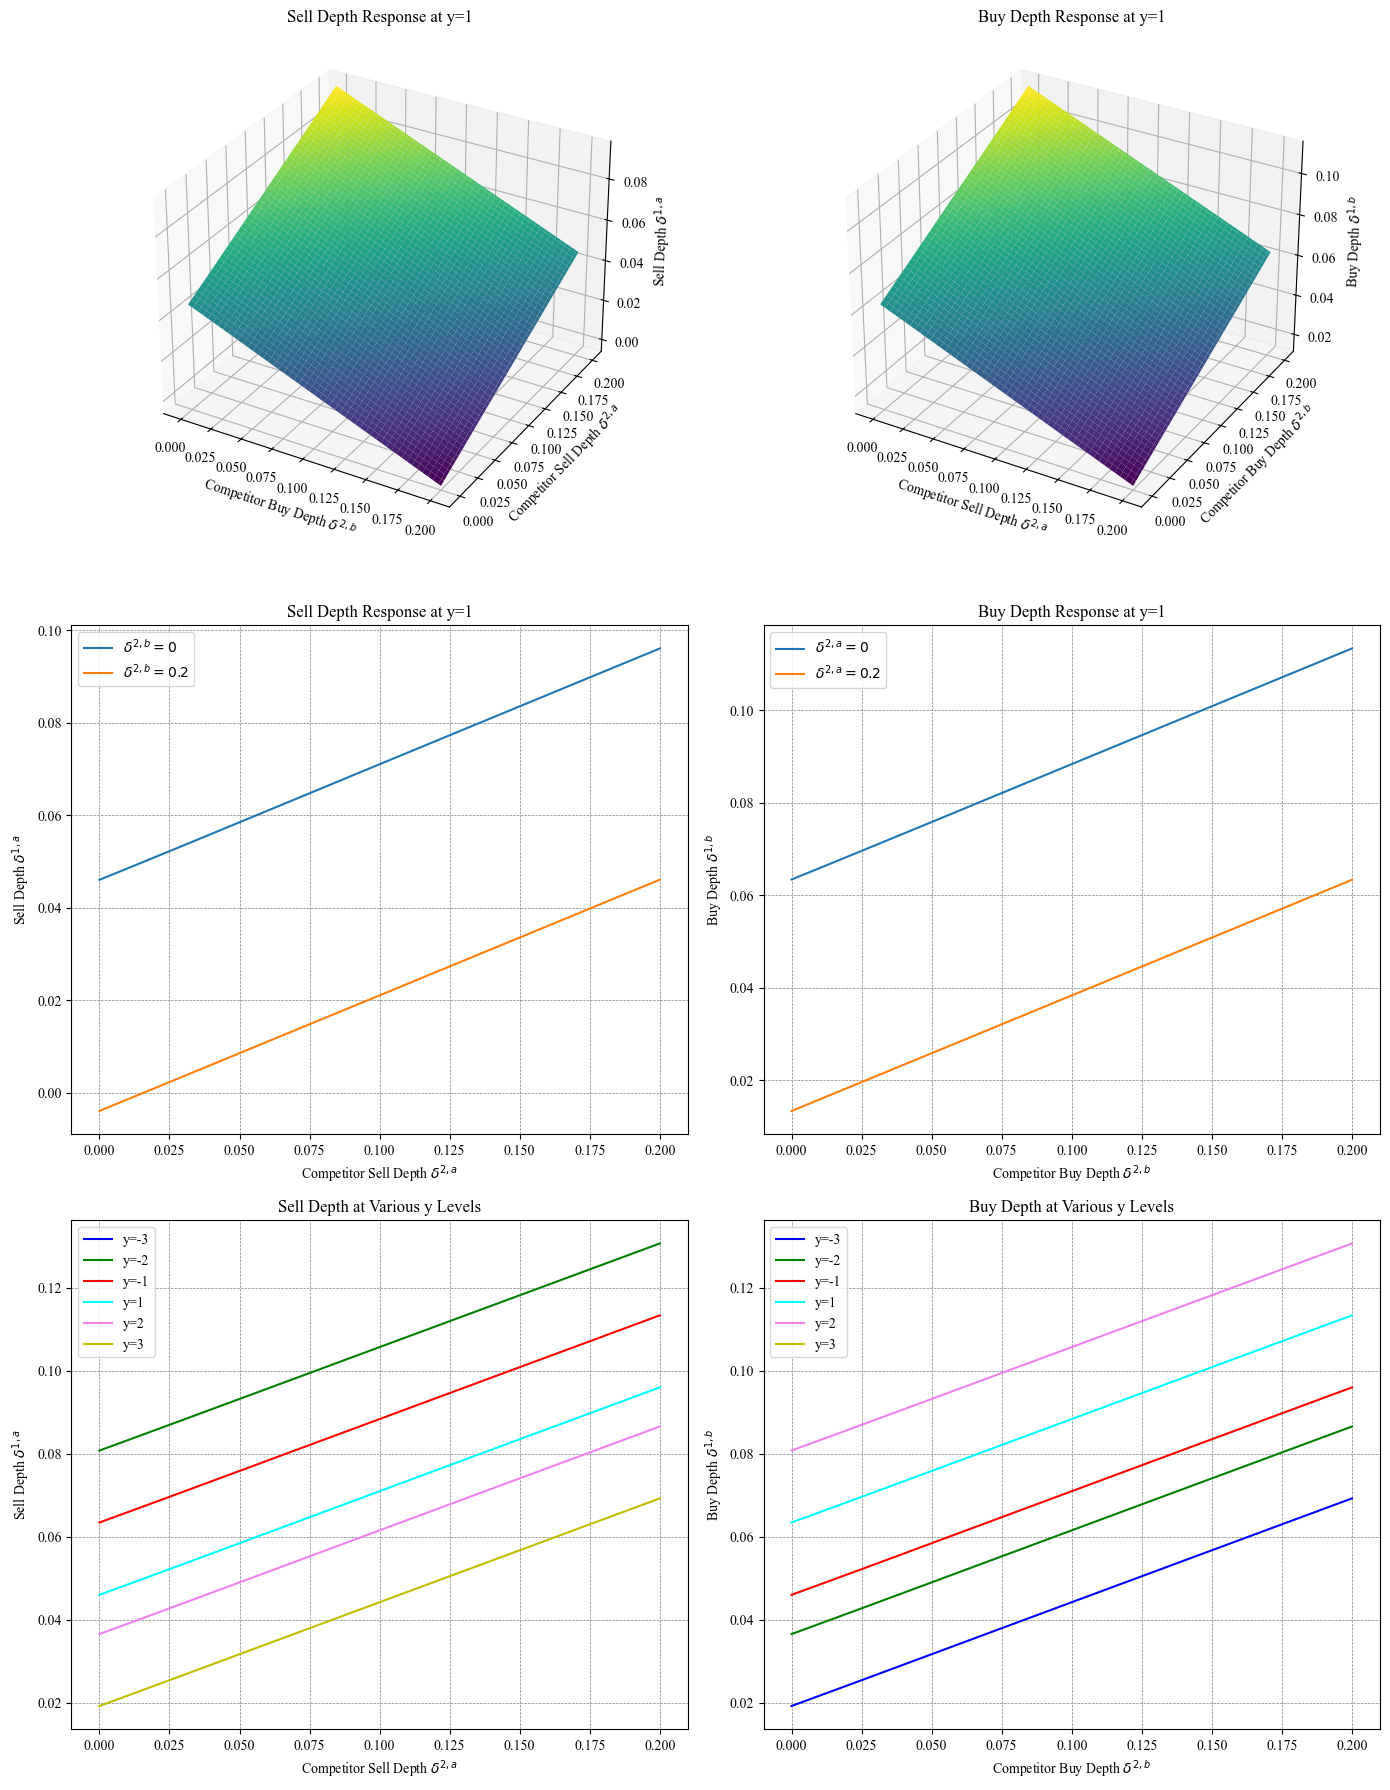

In [38]:
# B is the rows
# A is the columns
#Create the figures
fig = plt.figure(figsize=(14, 18))  # Increased figure size for better readability

# Plotting the 3D surfaces for sell depth
ax1 = fig.add_subplot(3, 2, 1, projection='3d')
surface1 = ax1.plot_surface(Y_delta_b_2, X_delta_a_2, delta_a_star[3, :, :], cmap='viridis', edgecolor='none')
ax1.set_title('Sell Depth Response at y=1')
ax1.set_ylabel('Competitor Sell Depth $\delta^{2,a}$')
ax1.set_xlabel('Competitor Buy Depth $\delta^{2,b}$')
ax1.set_zlabel('Sell Depth $\delta^{1,a}$')
ax1.set_facecolor((1, 1, 1))  # Change background to white


# Plotting the 3D surfaces for buy depth
ax2 = fig.add_subplot(3, 2, 2, projection='3d')
surface2 = ax2.plot_surface(X_delta_a_2, Y_delta_b_2, delta_b_star[3, :, :], cmap='viridis', edgecolor='none')
ax2.set_title('Buy Depth Response at y=1')
ax2.set_xlabel('Competitor Sell Depth $\delta^{2,a}$')
ax2.set_ylabel('Competitor Buy Depth $\delta^{2,b}$')
ax2.set_zlabel('Buy Depth $\delta^{1,b}$')
ax2.set_facecolor((1, 1, 1))  # Change background to white


# 2D plots for varying competitor depths at different inventory levels
ax3 = fig.add_subplot(3, 2, 3)
ax3.plot(delta_a_2, delta_a_star[3, 0,:], label='$\delta^{2,b}=0$')
ax3.plot(delta_a_2, delta_a_star[3,-1,:], label='$\delta^{2,b}=0.2$')
ax3.set_title('Sell Depth Response at y=1')
ax3.set_xlabel('Competitor Sell Depth $\delta^{2,a}$')
ax3.set_ylabel('Sell Depth $\delta^{1,a}$')
ax3.legend()
ax3.grid(True, color='gray', linestyle='--', linewidth=0.5)

ax4 = fig.add_subplot(3, 2, 4)
ax4.plot(delta_b_2, delta_b_star[3, :, 0], label='$\delta^{2,a}=0$')
ax4.plot(delta_b_2, delta_b_star[3, :, -1], label='$\delta^{2,a}=0.2$')
ax4.set_title('Buy Depth Response at y=1')
ax4.set_xlabel('Competitor Buy Depth $\delta^{2,b}$')
ax4.set_ylabel('Buy Depth $\delta^{1,b}$')
ax4.legend()
ax4.grid(True, color='gray', linestyle='--', linewidth=0.5)

colors = ['blue', 'green', 'red', 'cyan', 'violet', 'y']

# 2D plots for varying competitor depths at different inventory levels
ax5 = fig.add_subplot(3, 2, 5)
for i, y in enumerate(y_test_range):
    ax5.plot(delta_a_2, delta_a_star[i, 0, :], label=f'y={y}',color=colors[i])
ax5.set_title('Sell Depth at Various y Levels')
ax5.set_xlabel('Competitor Sell Depth $\delta^{2,a}$')
ax5.set_ylabel('Sell Depth $\delta^{1,a}$')
ax5.legend()
ax5.grid(True, color='gray', linestyle='--', linewidth=0.5)

ax6 = fig.add_subplot(3, 2, 6)
for i, y in enumerate(y_test_range):
    ax6.plot(delta_b_2, delta_b_star[i, :, 0], label=f'y={y}', color=colors[i])
ax6.set_title('Buy Depth at Various y Levels')
ax6.set_xlabel('Competitor Buy Depth $\delta^{2,b}$')
ax6.set_ylabel('Buy Depth $\delta^{1,b}$')
ax6.legend()
ax6.grid(True, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('Varying competing depth Model 1.a.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

### Simulating for non-competitive LP2: S cheaper that Z, different y values with Z constant, y_hat=0
We will compare how the depth of an LP would vary as he is far away from his objective

### Simulating for non-competitive LP2: S more expensive that Z, different y values with Z constant, y_hat=0
We will compare how the depth of an LP would vary as he is far away from his objective

### Simulating for competitive LP2: S=Z1=Z2, different y values with Z constant, y_hat=0
We will compare how the depth of an LP would vary as he is far away from his objective

In [39]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-2) # No inventory penalty
alpha1 = 10**(-1) # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y

delta_a_2=0.01;
delta_b_2=0.01;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_1 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_1 = np.zeros((len(y_test_range),len(t_grid)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_1[i,j], delta_a_star_1[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2,delta_a_2,delta_b_2)

In [40]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi11 = np.linspace(10**(-1),10**(-2)) # No inventory penalty
alpha1 = 0.1 # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y

delta_a_2=0.01;
delta_b_2=0.01;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[-1]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_2 = np.zeros((len(y_test_range),len(phi11)))
delta_a_star_2 = np.zeros((len(y_test_range),len(phi11)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, phi in enumerate(phi11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_2[i,j], delta_a_star_2[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2,delta_a_2,delta_b_2)

In [41]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-2) # No inventory penalty
alpha11 = np.linspace(10**(-0),10**(-1)) # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y

delta_a_2=0.01;
delta_b_2=0.01;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[-1]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_3 = np.zeros((len(y_test_range),len(alpha11)))
delta_a_star_3 = np.zeros((len(y_test_range),len(alpha11)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, alpha in enumerate(alpha11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_3[i,j], delta_a_star_3[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2,delta_a_2,delta_b_2)

In [42]:
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-2) # No inventory penalty
alpha1 = 10**(-1) # No terminal penalty
kappa11= np.linspace(1,30)
hat_y1 = 0 #objective y

delta_a_2=0.01;
delta_b_2=0.01;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[-1]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_4 = np.zeros((len(y_test_range),len(kappa11)))
delta_a_star_4 = np.zeros((len(y_test_range),len(kappa11)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, kappa in enumerate(kappa11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_4[i,j], delta_a_star_4[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2,delta_a_2,delta_b_2)

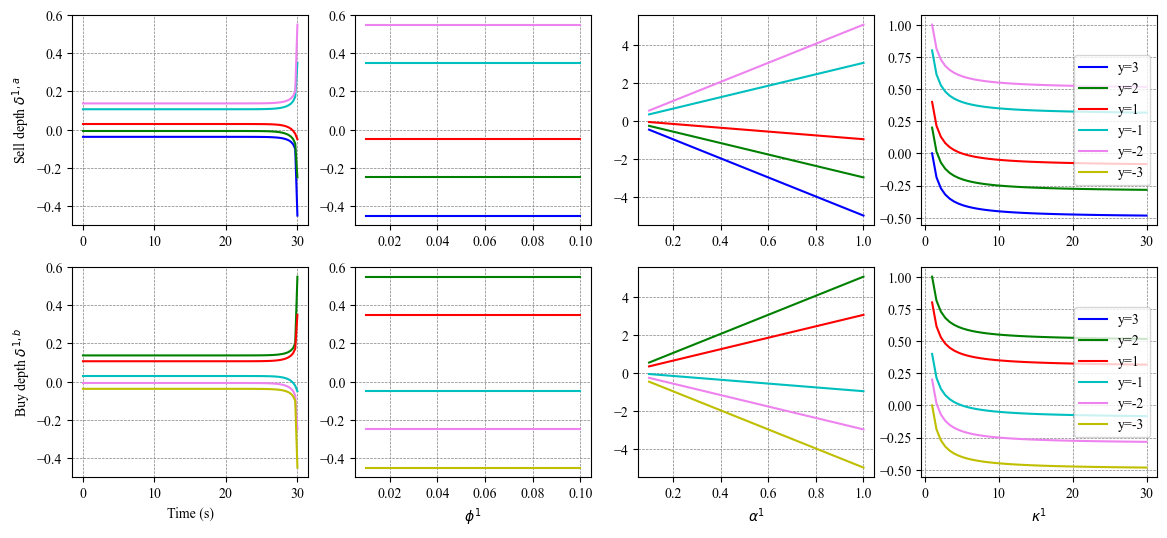

In [43]:
plt.figure(figsize=(14,6))


plt.subplot(2,4,1)
plt.plot(t_grid,delta_a_star_1[5,:],'b',label='y=3')
plt.plot(t_grid,delta_a_star_1[4,:],'g',label='y=2')
plt.plot(t_grid,delta_a_star_1[3,:],'r',label='y=1')
plt.plot(t_grid,delta_a_star_1[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_a_star_1[1,:],'violet',label='y=-2')
plt.plot(t_grid,delta_a_star_1[0,:],'y',label='y=-3')
plt.ylabel('Sell depth $\delta^{1,a}$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,5)
plt.plot(t_grid,delta_b_star_1[5,:],'b',label='y=3')
plt.plot(t_grid,delta_b_star_1[4,:],'g',label='y=2')
plt.plot(t_grid,delta_b_star_1[3,:],'r',label='y=1')
plt.plot(t_grid,delta_b_star_1[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_b_star_1[1,:],'violet',label='y=-2')
plt.plot(t_grid,delta_b_star_1[0,:],'y',label='y=-3')
plt.xlabel('Time (s)')
plt.ylabel('Buy depth $\delta^{1,b}$');
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.subplot(2,4,2)
plt.plot(phi11,delta_a_star_2[5,:],'b',label='y=3')
plt.plot(phi11,delta_a_star_2[4,:],'g',label='y=2')
plt.plot(phi11,delta_a_star_2[3,:],'r',label='y=1')
plt.plot(phi11,delta_a_star_2[2,:],'c',label='y=-1')
plt.plot(phi11,delta_a_star_2[1,:],'violet',label='y=-2')
plt.plot(phi11,delta_a_star_2[0,:],'y',label='y=-3')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,6)
plt.plot(phi11,delta_b_star_2[5,:],'b',label='y=3')
plt.plot(phi11,delta_b_star_2[4,:],'g',label='y=2')
plt.plot(phi11,delta_b_star_2[3,:],'r',label='y=1')
plt.plot(phi11,delta_b_star_2[2,:],'c',label='y=-1')
plt.plot(phi11,delta_b_star_2[1,:],'violet',label='y=-2')
plt.plot(phi11,delta_b_star_2[0,:],'y',label='y=-3')
plt.xlabel('$\\phi^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.subplot(2,4,3)
plt.plot(alpha11,delta_a_star_3[5,:],'b',label='y=3')
plt.plot(alpha11,delta_a_star_3[4,:],'g',label='y=2')
plt.plot(alpha11,delta_a_star_3[3,:],'r',label='y=1')
plt.plot(alpha11,delta_a_star_3[2,:],'c',label='y=-1')
plt.plot(alpha11,delta_a_star_3[1,:],'violet',label='y=-2')
plt.plot(alpha11,delta_a_star_3[0,:],'y',label='y=-3')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,7)
plt.plot(alpha11,delta_b_star_3[5,:],'b',label='y=3')
plt.plot(alpha11,delta_b_star_3[4,:],'g',label='y=2')
plt.plot(alpha11,delta_b_star_3[3,:],'r',label='y=1')
plt.plot(alpha11,delta_b_star_3[2,:],'c',label='y=-1')
plt.plot(alpha11,delta_b_star_3[1,:],'violet',label='y=-2')
plt.plot(alpha11,delta_b_star_3[0,:],'y',label='y=-3')
plt.xlabel('$\\alpha^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.subplot(2,4,4)
plt.plot(kappa11,delta_a_star_4[5,:],'b',label='y=3')
plt.plot(kappa11,delta_a_star_4[4,:],'g',label='y=2')
plt.plot(kappa11,delta_a_star_4[3,:],'r',label='y=1')
plt.plot(kappa11,delta_a_star_4[2,:],'c',label='y=-1')
plt.plot(kappa11,delta_a_star_4[1,:],'violet',label='y=-2')
plt.plot(kappa11,delta_a_star_4[0,:],'y',label='y=-3')
plt.legend(loc='center right')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,8)
plt.plot(kappa11,delta_b_star_4[5,:],'b',label='y=3')
plt.plot(kappa11,delta_b_star_4[4,:],'g',label='y=2')
plt.plot(kappa11,delta_b_star_4[3,:],'r',label='y=1')
plt.plot(kappa11,delta_b_star_4[2,:],'c',label='y=-1')
plt.plot(kappa11,delta_b_star_4[1,:],'violet',label='y=-2')
plt.plot(kappa11,delta_b_star_4[0,:],'y',label='y=-3')
plt.legend(loc='center right')
plt.xlabel('$\\kappa^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.savefig('General analysis Model 1.a with competing depths.png', format='png', dpi=300, bbox_inches='tight')